### **Preleukemia scRNAseq Sample Analysis (Part 2 in Python)**
#### *Naraen Palanikumar*

This is part 2 of the analysis and dashboarding project completed using publicly available scRNAseq/gene signature/reference atlas data from this paper (https://doi.org/10.1016/j.xgen.2023.100426) concerning gene markers associated with determine Acute myeloid leukemia (AML) afflicted patient outcomes and AML clinical data from NCI.

In [17]:
# --- Imports Section 1 ---
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import seaborn as sns
from gprofiler import GProfiler
import matplotlib.pyplot as plt

In [18]:
# --- Load Data ---
adata = sc.read_h5ad("data/seurat_inter/seurat_integrated.h5ad")

In [19]:
# --- Prepare Data ---
adada = sc.pp.subsample(adata, n_obs=30000) #need to subsample to avoid crashing when computing fate probabilities
adata.obs['celltype'] = adata.obs['predicted.id']
adata = adata[adata.obs['celltype'] != 'Unassigned'].copy()
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [20]:
# --- Cell Rank Workflow ---
#running nearest neighbors and diffmap
sc.pp.neighbors(adata) # This computes the nearest-neighbor graph
sc.tl.diffmap(adata)

In [21]:
#root cell
root_cell_name = adata.obs_names[adata.obs['celltype'] == 'HSCs'][0]
root_cell_index = np.where(adata.obs_names == root_cell_name)[0][0]
adata.uns['iroot'] = root_cell_index
sc.tl.dpt(adata, n_dcs = 10)

In [22]:
#transition matrix
kernel = cr.kernels.PseudotimeKernel(adata, time_key='dpt_pseudotime')
kernel.compute_transition_matrix()

  0%|          | 0/29515 [00:00<?, ?cell/s]

100%|██████████| 29515/29515 [00:02<00:00, 11383.57cell/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[62137,0],0]
  Errorcode: 59

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


PseudotimeKernel[n=29515, dnorm=False, scheme='hard', frac_to_keep=0.3]

In [23]:
#fate probabilities
estimator = cr.estimators.GPCCA(kernel)
estimator.compute_schur(n_components=15)
estimator.compute_macrostates(n_states=8, cluster_key="celltype")

GPCCA[kernel=PseudotimeKernel[n=29515], initial_states=None, terminal_states=None]

In [24]:
#correcting end states and start states
print("Identified macrostates:", list(estimator.macrostates.unique()))
hsc_mask = (adata.obs['celltype'] == 'HSCs')
initial_states_series = pd.Series(None, index=adata.obs_names, dtype="object")
initial_states_series[hsc_mask] = 'HSCs'
start_states = initial_states_series.astype('category')
end_states = list(estimator.macrostates.unique())[1:]

Identified macrostates: [nan, 'Neu', 'Late_Ery', 'Immature_3', 'Megakry', 'Mast', 'Immature_1', 'Early_Ery', 'Immature_2']


In [25]:
#runs the estimator
estimator.set_terminal_states(end_states)
estimator.set_initial_states(start_states)

GPCCA[kernel=PseudotimeKernel[n=29515], initial_states=['HSCs'], terminal_states=[np.str_('Early_Ery'), np.str_('Immature_1'), np.str_('Immature_2'), np.str_('Immature_3'), np.str_('Late_Ery'), np.str_('Mast'), np.str_('Megakry'), np.str_('Neu')]]

In [26]:
#compute fate probabilities
estimator.compute_fate_probabilities(solver = 'direct', n_jobs = -1, backend = 'loky', show_progress_bar = True)

/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


saving figure to file ./figures/scvelo_macrostates.png


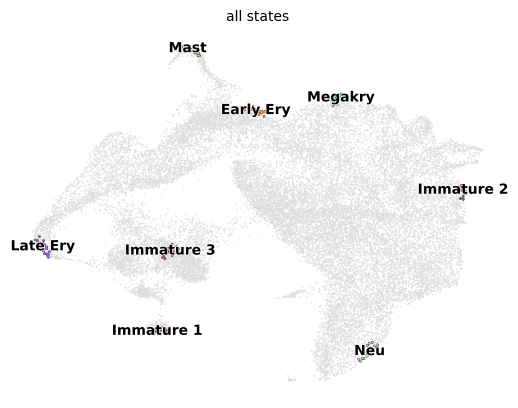

/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/naraenpc/envs/preleuk_env1/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_fate_probabilities.png


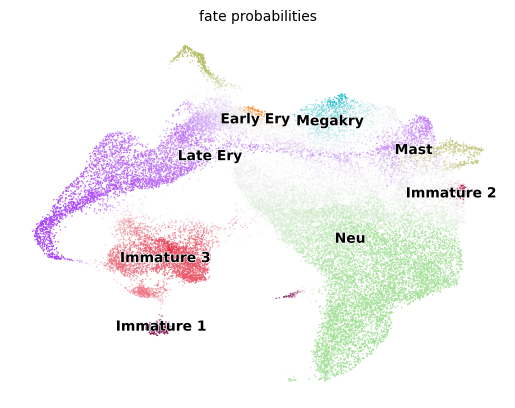

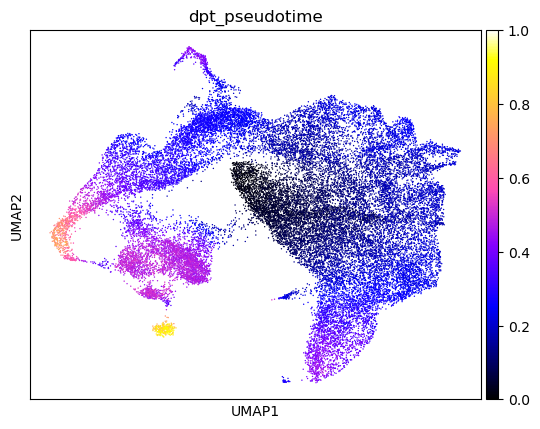

In [27]:
#plot these on umap
sc.tl.umap(adata)

estimator.plot_macrostates(which = 'all', save='macrostates.png')
estimator.plot_fate_probabilities(save='fate_probabilities.png')

sc.pl.umap(
    adata,
    color='dpt_pseudotime', # Use the existing column
    cmap='gnuplot2',
    save='dpt_pseudotime.png'
)

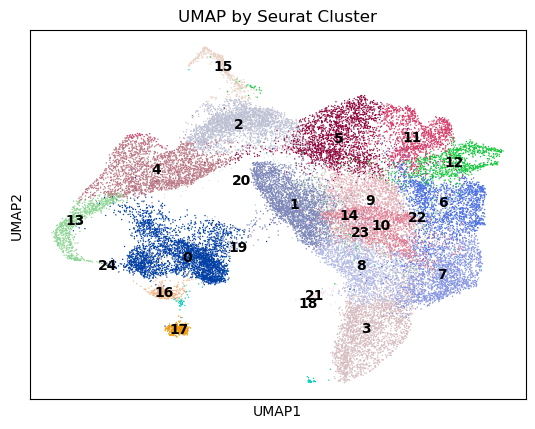

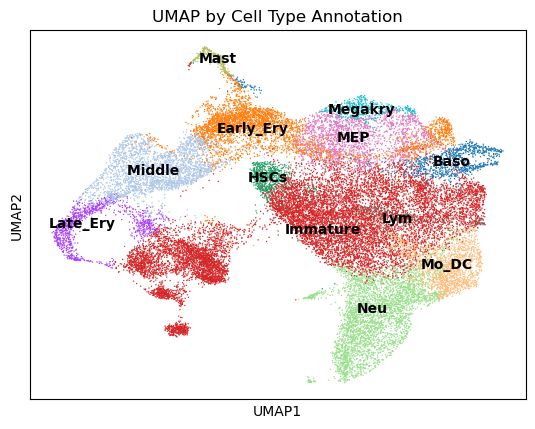

In [28]:
#standard umap for comparison
sc.pl.umap(
    adata,
    color='seurat_clusters',
    legend_loc='on data',
    title='UMAP by Seurat Cluster',
    save='umap_seurat_clusters.png'
)

sc.pl.umap(
    adata,
    color='celltype',
    legend_loc='on data',
    title='UMAP by Cell Type Annotation',
    save='umap_celltype.png'
)

In [29]:
#make sure condition is categorical and find diffex genes (need to rename columns)
sc.tl.rank_genes_groups(adata, groupby='condition', method='wilcoxon', reference='WT')
adata.obs['condition'] = adata.obs['condition'].astype('category')
result = adata.uns['rank_genes_groups']
group_to_show = 'Mutant'
corrected_deg_df = pd.DataFrame()
gene_indices_raw = result['names'][group_to_show]
gene_indices_int = gene_indices_raw.astype(int)
corrected_deg_df['names'] = [adata.var_names[i] for i in gene_indices_int]
corrected_deg_df['logfoldchanges'] = result['logfoldchanges'][group_to_show]
corrected_deg_df['pvals_adj'] = result['pvals_adj'][group_to_show]
corrected_deg_df['scores'] = result['scores'][group_to_show]
print(corrected_deg_df.head(20))

      names  logfoldchanges      pvals_adj     scores
0       Rhd        0.025462  1.252964e-112  22.801950
1   Sec14l2        0.834204  8.665281e-108  22.297590
2     Hmox1        1.135672   4.322892e-76  18.712843
3       Hpn        0.219815   5.366257e-71  18.068579
4      Lgmn        0.958224   1.459739e-58  16.393835
5       Cfp        0.144580   3.430466e-51  15.307047
6      Dntt       -0.010925   4.573612e-48  14.826784
7      Acp5        0.392744   4.140077e-46  14.515046
8    Hba-a1        0.440603   6.001609e-44  14.159979
9      Aqp9       -0.166891   1.336048e-43  14.099813
10   Wfdc17        0.066066   2.494289e-40  13.539796
11   S100a8        0.336902   7.449653e-37  12.925293
12    Ermap       -0.285752   3.454621e-36  12.803272
13   Atp1b2       -0.203241   4.110505e-34  12.414569
14     C1qa        1.419061   3.252558e-33  12.243442
15    Pdia2        1.840620   7.021671e-32  11.987282
16    Itgax        2.039014   2.395955e-29  11.487002
17      Bmx        0.291012 

In [30]:
#metabolic pathway gene enrichment analysis
upregulated_genes = corrected_deg_df[(corrected_deg_df['pvals_adj'] < 0.05) & (corrected_deg_df['logfoldchanges'] > 0)]
gene_list = upregulated_genes['names'].tolist()

gp = GProfiler(return_dataframe=True)
    
go_results = gp.profile(
    query=gene_list,
    organism='hsapiens'
)

biological_processes = go_results[go_results['source'] == 'GO:BP']
metabolic_keywords = ['METABOLIC', 'GLYCOLYSIS', 'GLUCOSE', 'RESPIRATION', 'TCA', 'KREBS', 'FATTY_ACID', 'OXIDATIVE_PHOSPHORYLATION', 'METABOLISM', 'GLYCOLYTIC']
metabolic_terms = biological_processes[biological_processes['name'].str.contains('|'.join(metabolic_keywords), case=False)]
print(metabolic_terms.sort_values('p_value')[['p_value', 'name', 'intersection_size']].head(20))

      p_value                                       name  intersection_size
212  0.007842  reactive oxygen species metabolic process                 13
237  0.015437                    lipid metabolic process                 36
280  0.036675               superoxide metabolic process                  7


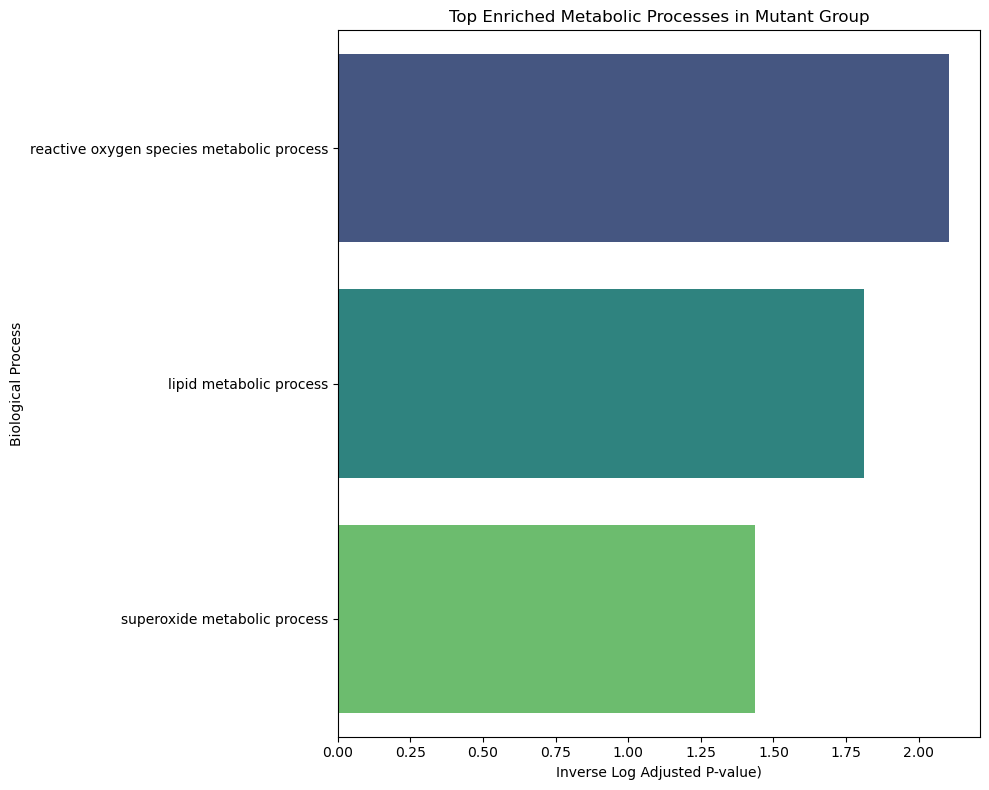

In [31]:
#plotting metabolic pathway values
plot_df = metabolic_terms.sort_values('p_value')[['p_value', 'name', 'intersection_size']].head(15)
plot_df['norm_pval'] = (-1)*(np.log10(plot_df['p_value']))

plt.figure(figsize=(10, 8))
sns.barplot(
    data=plot_df,
    x='norm_pval',
    y='name',
    palette='viridis'
)

plt.title('Top Enriched Metabolic Processes in Mutant Group')
plt.xlabel('Inverse Log Adjusted P-value)')
plt.ylabel('Biological Process')
plt.tight_layout()
plt.savefig('preleuk_dashboard/plots/invlogp_metabolicpathways')
plt.show()

In [32]:
adata_to_export = adata
umap_coords = pd.DataFrame(adata_to_export.obsm['X_umap'], index=adata_to_export.obs_names)
umap_coords.columns = ['UMAP_1', 'UMAP_2']
cell_metadata = adata_to_export.obs[['celltype', 'condition']]
df_for_shiny = pd.concat([umap_coords, cell_metadata], axis=1)
df_for_shiny.to_csv('preleuk_dashboard/data/umap_data_for_shiny.csv')